# Medical Text

Medical Text Dataset [https://www.kaggle.com/datasets/chaitanyakck/medical-text/data]

In [1]:
import pandas as pd
import nltk
from spacy import displacy
import spacy
from transformers import pipeline
import pickle
import json
import os
import stanza
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/train.dat', sep="\t", header=None)

In [3]:
df.rename(columns={0:'condition', 1:'abstract'}, inplace=True)
df.head()

,condition,abstract
0,4,Catheterization laboratory events and hospital...
1,5,Renal abscess in children. Three cases of rena...
2,2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,5,Subclavian artery to innominate vein fistula a...
4,4,Effect of local inhibition of gamma-aminobutyr...


In order to perform NLP we decided to not include records labelled as "general pathological conditions" due to the amount of data we have. The remaining dataset will provide a sufficient amount of information.

In [4]:
df.drop(index=df[df["condition"]==5].index,inplace=True)

In [5]:
# replace each number with the corresponding condition
mapping = {
    'condition': {1: "neoplasm",
                  2: "digestive system disease",
                  3: "nervous system disease",
                  4: "cardiovascular disease"}
}

df.replace(mapping, inplace = True)

In [6]:
# display changes
df.head()

,condition,abstract
0,cardiovascular disease,Catheterization laboratory events and hospital...
2,digestive system disease,Hyperplastic polyps seen at sigmoidoscopy are ...
4,cardiovascular disease,Effect of local inhibition of gamma-aminobutyr...
5,neoplasm,Infection during chronic epidural catheterizat...
8,nervous system disease,Multiple representations contribute to body kn...


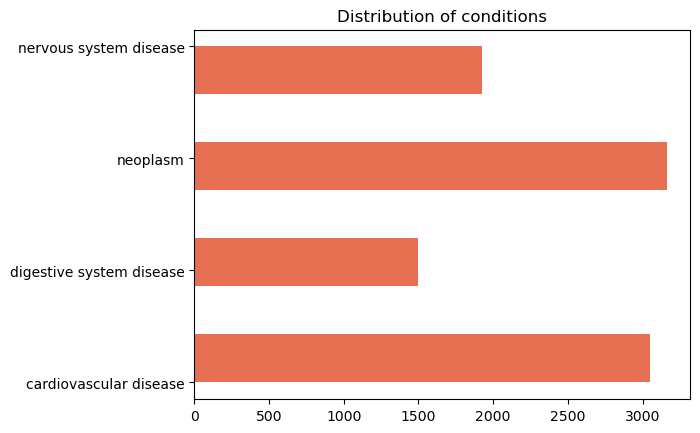

In [7]:
plt.hist(df['condition'], orientation='horizontal', bins=7, color='#e76f51');
plt.title('Distribution of conditions');

In [8]:
df.condition.value_counts()

condition
neoplasm                    3163
cardiovascular disease      3051
nervous system disease      1925
digestive system disease    1494
Name: count, dtype: int64

The dataset provides a major collection of abstracts labelled as "neoplasm" and "cardiovascular disease"

# Lexical Analysis
Lexical analysis consists of the operations of:
- **Sentence Splitting**: The technique aims to identify the beginning and end of a textual fragment (sentence or clause) with informative content, even if simple. To achieve this, it uses orthographic features of words (e.g., uppercase initial letters) and delimiters (e.g., punctuation).
- **Tokenization**: The goal of tokenization is to pinpoint the starting and ending positions of each token, whether it’s a word, a number, or a combination of symbols. As with sentence splitting, the process relies on orthographic features (e.g., initial capital letters) and delimiters (e.g., punctuation).
- **Lemmatization**: Post-tokenization techniques address the morphological analysis of word-tokens. Lemmatization identifies the base form (lemma) of inflected words, preserving their meaning and grammatical category. For example, the token _liked_ maps to the lemma *like*. This process minimizes lexical variation by consolidating different forms of the same word into a unified representation.
- **Stemming**: Like lemmatization, processes inflected forms but reduces them to their root, which may not correspond to a dictionary word. Unlike lemmatization, it focuses on inflections that create new words and may change the grammatical class, such as *probable* (adjective) stemming to *probably* (adverb).
- **POS Tagging**: Part-of-speech (POS) tagging assigns a grammatical category to each token, such as noun, verb, or adjective

It focuses on the main components of a text (words), and aims to recognize them in relation to the context in which they are used, such as sentences or clauses.

### Funzioni utili
From now on there will be repetitive steps in order to check files existence prior to create each one: the following functions aims to simplify the process.

In [9]:
def check_existence(obj):
    """
    checks if we already stored the file
    Arg:
    obj = str name of the object
    """
    path = 'objects/'+obj+'.pkl'
    if os.path.exists(path):
        with open(path, 'rb') as file:
            file = pickle.load(file)
            return file
    else:
        return False

In [10]:
def save_step(name, obj):
    """
    Saves object to pickle and json files
    Args:
    name = 'obj_name'
    obj = object to save
    """

    with open('objects/'+name+'.pkl', 'wb') as file:
        pickle.dump(obj, file)

    with open('objects/'+name+'.json', 'w') as file:
        json.dump(obj, file)

In [11]:
lexical_df = df.copy() # a df to compute lexical analysis on

## Sentence Splitting, Word Tokenization, Lemmatization, Stemming and POS Tagging
We performed lexical analysis with Stanza, a collection of accurate and efficient tools for the linguistic analysis of many human languages.


In [12]:
# set the pipeline choosing English vocabulary and NLP functions to perform
snlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

2025-02-19 15:32:52 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-02-19 15:32:53 INFO: Downloaded file to C:\Users\claud\stanza_resources\resources.json
2025-02-19 15:32:53 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2025-02-19 15:32:53 INFO: Using device: cpu
2025-02-19 15:32:53 INFO: Loading: tokenize
2025-02-19 15:32:54 INFO: Loading: mwt
2025-02-19 15:32:54 INFO: Loading: pos
2025-02-19 15:32:56 INFO: Loading: lemma
2025-02-19 15:32:56 INFO: Loading: depparse
2025-02-19 15:32:56 INFO: Done loading processors!


In [13]:
if check_existence('sentences'): # if the first obj exists for sure we created the others(?)
    sentences = check_existence('sentences')
    words = check_existence('words')
    lemmatization = check_existence('lemmatization')
    pos_tag = check_existence('pos_tag')

else:
    sentences = []
    words = []
    lemmatization = []
    pos_tag = []

    # iter on df records
    for record in lexical_df["abstract"]:
        doc = snlp(record)
        split_record = [[sent.text] for sent in doc.sentences] # sentence splitting
        tokenized_record = []
        lemmatized_record = []
        pos_tag_record = []

        # iter on each sentence of the record
        for sentence in doc.sentences:
            tokenized_sent = [(word.id, word.text) for word in sentence.tokens] # tokenization + id position
            lemmatized_sent = [(word.text, word.lemma) if word.text != word.lemma else word.lemma for word in sentence.words] # lemmatization
            pos_tag_sent = [(word.text, word.upos, word.xpos) for word in sentence.words] # POS tagging: universal POS tags and treebank-specific POS tags

            tokenized_record.append(tokenized_sent)  # add tokenized sentence to list
            lemmatized_record.append(lemmatized_sent) # add lemmatized sentence to list
            pos_tag_record.append(pos_tag_sent) # add POS taggend sentence to list

        sentences.append(split_record) # add record to list
        words.append(tokenized_record) # add tokenized record to list
        lemmatization.append(lemmatized_record) # add lemmatized record to list
        pos_tag.append(pos_tag_record) # add POS tagged record to list

    # Save each step to a file
    save_step('sentences',sentences)
    save_step('words',words)
    save_step('lemmatization',lemmatization)
    save_step('pos_tag',pos_tag)

In [14]:
# set each list as df columns to save progress
lexical_df["sentences"] = sentences
lexical_df['words'] = words
lexical_df['lemmatization'] = lemmatization
lexical_df['pos_tag'] = pos_tag

In [15]:
# display df
lexical_df.head()

,condition,abstract,sentences,words,lemmatization,pos_tag
0,cardiovascular disease,Catheterization laboratory events and hospital...,[[Catheterization laboratory events and hospit...,"[[((1,), Catheterization), ((2,), laboratory),...","[[(Catheterization, catheterization), laborato...","[[(Catheterization, NOUN, NN), (laboratory, NO..."
2,digestive system disease,Hyperplastic polyps seen at sigmoidoscopy are ...,[[Hyperplastic polyps seen at sigmoidoscopy ar...,"[[((1,), Hyperplastic), ((2,), polyps), ((3,),...","[[(Hyperplastic, hyperplastic), (polyps, polyp...","[[(Hyperplastic, ADJ, JJ), (polyps, NOUN, NNS)..."
4,cardiovascular disease,Effect of local inhibition of gamma-aminobutyr...,[[Effect of local inhibition of gamma-aminobut...,"[[((1,), Effect), ((2,), of), ((3,), local), (...","[[(Effect, effect), of, local, inhibition, of,...","[[(Effect, NOUN, NN), (of, ADP, IN), (local, A..."
5,neoplasm,Infection during chronic epidural catheterizat...,[[Infection during chronic epidural catheteriz...,"[[((1,), Infection), ((2,), during), ((3,), ch...","[[(Infection, infection), during, chronic, epi...","[[(Infection, NOUN, NN), (during, ADP, IN), (c..."
8,nervous system disease,Multiple representations contribute to body kn...,[[Multiple representations contribute to body ...,"[[((1,), Multiple), ((2,), representations), (...","[[(Multiple, multiple), (representations, repr...","[[(Multiple, ADJ, JJ), (representations, NOUN,..."


In [16]:
# an example of sentence splitting result for the first record
sentences[0][0]

['Catheterization laboratory events and hospital outcome with direct angioplasty for acute myocardial infarction To assess the safety of direct infarct angioplasty without antecedent thrombolytic therapy, catheterization laboratory and hospital events were assessed in consecutively treated patients with infarctions involving the left anterior descending (n = 100 patients), right (n = 100), and circumflex (n = 50) coronary arteries.']

## Stop-words Removal
Stop-words are common words that do not carry specific meaning, such as articles, prepositions, and conjunctions.
It is usually performed after lexical analysis to avoid inaccuracies in subsequent syntactic or semantic analyses.

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\claud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
stopwords = nltk.corpus.stopwords.words('english')

if check_existence('stopwords_removal'):
    stopwords_removal = check_existence('stopwords_removal')
else:
    stopwords_removal = []

    for record in lexical_df['sentences']:
        filtered_record = []
        for sentence in record:
            filtered_sentence = [word for word in sentence if word.lower() not in stopwords]
            filtered_record.append(filtered_sentence)

        stopwords_removal.append(filtered_record)

    save_step('stopwords_removal',stopwords_removal)

In [19]:
lexical_df["stopwords_removal"] = stopwords_removal

In [20]:
lexical_df.head()

,condition,abstract,sentences,words,lemmatization,pos_tag,stopwords_removal
0,cardiovascular disease,Catheterization laboratory events and hospital...,[[Catheterization laboratory events and hospit...,"[[((1,), Catheterization), ((2,), laboratory),...","[[(Catheterization, catheterization), laborato...","[[(Catheterization, NOUN, NN), (laboratory, NO...",[[Catheterization laboratory events and hospit...
2,digestive system disease,Hyperplastic polyps seen at sigmoidoscopy are ...,[[Hyperplastic polyps seen at sigmoidoscopy ar...,"[[((1,), Hyperplastic), ((2,), polyps), ((3,),...","[[(Hyperplastic, hyperplastic), (polyps, polyp...","[[(Hyperplastic, ADJ, JJ), (polyps, NOUN, NNS)...",[[Hyperplastic polyps seen at sigmoidoscopy ar...
4,cardiovascular disease,Effect of local inhibition of gamma-aminobutyr...,[[Effect of local inhibition of gamma-aminobut...,"[[((1,), Effect), ((2,), of), ((3,), local), (...","[[(Effect, effect), of, local, inhibition, of,...","[[(Effect, NOUN, NN), (of, ADP, IN), (local, A...",[[Effect of local inhibition of gamma-aminobut...
5,neoplasm,Infection during chronic epidural catheterizat...,[[Infection during chronic epidural catheteriz...,"[[((1,), Infection), ((2,), during), ((3,), ch...","[[(Infection, infection), during, chronic, epi...","[[(Infection, NOUN, NN), (during, ADP, IN), (c...",[[Infection during chronic epidural catheteriz...
8,nervous system disease,Multiple representations contribute to body kn...,[[Multiple representations contribute to body ...,"[[((1,), Multiple), ((2,), representations), (...","[[(Multiple, multiple), (representations, repr...","[[(Multiple, ADJ, JJ), (representations, NOUN,...",[[Multiple representations contribute to body ...


# Syntax Analysis
Syntax analysis consists of:
- Shallow Parsing
- Deep Parsing

## Shallow Parsing
Syntactic parsing extends chunking by generating a parse tree. This tree organizes POS-tagging results as leaf nodes and syntactic structures (often chunks) as intermediate nodes, connected hierarchically without representing specific relationships.


In [21]:
syntax_df = df.copy() # a df to compute syntax analysis on

In [22]:
if check_existence('chunking'):
    chunking = check_existence('chunking')

else:
    # Define the grammar and the chunk parser
    grammar = "NP: {<NNP><NNP>}"
    cp = nltk.RegexpParser(grammar) # chunk parser

    # Apply chunking to each record
    chunking = []
    for record in lexical_df['pos_tag']:
        chunked_record = [cp.parse(sentence) for sentence in record]

        chunking.append(chunked_record)

    save_step('chunking',chunking)

In [23]:
# Save the chunking results into the dataframe
syntax_df["shallow_parsing"] = chunking

In [24]:
# Display the dataframe
syntax_df.head()

,condition,abstract,shallow_parsing
0,cardiovascular disease,Catheterization laboratory events and hospital...,"[[(Catheterization, NOUN, NN), (laboratory, NO..."
2,digestive system disease,Hyperplastic polyps seen at sigmoidoscopy are ...,"[[(Hyperplastic, ADJ, JJ), (polyps, NOUN, NNS)..."
4,cardiovascular disease,Effect of local inhibition of gamma-aminobutyr...,"[[(Effect, NOUN, NN), (of, ADP, IN), (local, A..."
5,neoplasm,Infection during chronic epidural catheterizat...,"[[(Infection, NOUN, NN), (during, ADP, IN), (c..."
8,nervous system disease,Multiple representations contribute to body kn...,"[[(Multiple, ADJ, JJ), (representations, NOUN,..."


In [25]:
# Display the chunking result for the first record
print(syntax_df['shallow_parsing'][0][4])
#syntax_df['chunking'][0][4]

(S
  There/PRON/EX
  was/VERB/VBD
  one/NUM/CD
  in/ADP/IN
  -/PUNCT/HYPH
  laboratory/NOUN/NN
  death/NOUN/NN
  (/PUNCT/-LRB-
  shock/NOUN/NN
  patient/NOUN/NN
  with/ADP/IN
  infarction/NOUN/NN
  of/ADP/IN
  the/DET/DT
  left/ADJ/JJ
  anterior/ADJ/JJ
  descending/VERB/VBG
  coronary/NOUN/NN
  artery/NOUN/NN
  )/PUNCT/-RRB-
  ./PUNCT/.)


In [26]:
# To draw the parse tree
#syntax_df['chunking'][1][1].draw()

## Deep Parsing
Differently from _Shallow parsing_, _Deep parsing_ aims to infer dependency relationships between nodes.
The result is a dependency graph which relates words that are syntactically linked.

In [27]:
if check_existence('deep_parsing'):
    deep_parsing = check_existence('deep_parsing')
else:
    deep_parsing = []

    # Iterate over each abstract in your DataFrame.
    for text in syntax_df["abstract"]:
        doc = snlp(text)
        sentence_deps = []  # Stores dependency tuples for all sentences in this abstract.

        for sent in doc.sentences:
            words_dict = {word.id: word for word in sent.words}  # Map word IDs to word objects
            for word in sent.words:
                # Compute children by checking which words have this one as their head
                children = [w.text for w in sent.words if w.head == word.id]
                # Get head information
                head_idx = word.head  # Stanza gives a 1-based index
                head_text = words_dict[head_idx].text if head_idx > 0 and head_idx in words_dict else "root"

                # Create a tuple: (word text, dependency relation, head idx, head text, children list)
                sentence_deps.append((word.text, word.deprel, head_idx, head_text, children))

        deep_parsing.append(sentence_deps)

In [28]:
text = "The overall complication rate for the procedure was 20.5%, including vascular injury in 11%, embolic phenomenon in 2.2%, ventricular perforation resulting in tamponade in 1.8%, massive aortic insufficiency in 1%, nonfatal arrhythmia in 0.8% and myocardial infarction in 0.2%."
doc = snlp(text)
sentence_deps = []  # Stores dependency tuples for all sentences in this abstract.

for sent in doc.sentences:
    words_dict = {word.id: word for word in sent.words}  # Map word IDs to word objects
    for word in sent.words:
        # Compute children by checking which words have this one as their head
        children = [w.text for w in sent.words if w.head == word.id]
        # Get head information
        head_idx = word.head  # Stanza gives a 1-based index
        head_text = words_dict[head_idx].text if head_idx > 0 and head_idx in words_dict else "root"

        # Create a tuple: (word text, dependency relation, head idx, head text, children list)
        sentence_deps.append((word.text, word.deprel, head_idx, head_text, children))

In [29]:
sentence_deps

[('The', 'det', 4, 'rate', []),
 ('overall', 'amod', 4, 'rate', []),
 ('complication', 'compound', 4, 'rate', []),
 ('rate', 'nsubj', 10, '%', ['The', 'overall', 'complication', 'procedure']),
 ('for', 'case', 7, 'procedure', []),
 ('the', 'det', 7, 'procedure', []),
 ('procedure', 'nmod', 4, 'rate', ['for', 'the']),
 ('was', 'cop', 10, '%', []),
 ('20.5', 'nummod', 10, '%', []),
 ('%', 'root', 0, 'root', ['rate', 'was', '20.5', 'injury', '.']),
 (',', 'punct', 14, 'injury', []),
 ('including', 'case', 14, 'injury', []),
 ('vascular', 'amod', 14, 'injury', []),
 ('injury',
  'nmod',
  10,
  '%',
  [',', 'including', 'vascular', 'phenomenon', 'perforation']),
 ('in', 'case', 17, '%', []),
 ('11', 'nummod', 17, '%', []),
 ('%', 'nmod', 20, 'phenomenon', ['in', '11']),
 (',', 'punct', 20, 'phenomenon', []),
 ('embolic', 'amod', 20, 'phenomenon', []),
 ('phenomenon', 'conj', 14, 'injury', ['%', ',', 'embolic', '%']),
 ('in', 'case', 23, '%', []),
 ('2.2', 'nummod', 23, '%', []),
 ('%', 'nm

In [31]:
# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

In [32]:
syntax_df["deep_parsing"] = deep_parsing

In [33]:
syntax_df.head()

,condition,abstract,shallow_parsing,deep_parsing
0,cardiovascular disease,Catheterization laboratory events and hospital...,"[[(Catheterization, NOUN, NN), (laboratory, NO...","[(Catheterization, compound, 3, events, []), (..."
2,digestive system disease,Hyperplastic polyps seen at sigmoidoscopy are ...,"[[(Hyperplastic, ADJ, JJ), (polyps, NOUN, NNS)...","[(Hyperplastic, amod, 2, polyps, []), (polyps,..."
4,cardiovascular disease,Effect of local inhibition of gamma-aminobutyr...,"[[(Effect, NOUN, NN), (of, ADP, IN), (local, A...","[(Effect, root, 0, root, [inhibition, study, ...."
5,neoplasm,Infection during chronic epidural catheterizat...,"[[(Infection, NOUN, NN), (during, ADP, IN), (c...","[(Infection, root, 0, root, [catheterization, ..."
8,nervous system disease,Multiple representations contribute to body kn...,"[[(Multiple, ADJ, JJ), (representations, NOUN,...","[(Multiple, amod, 2, representations, []), (re..."


In [34]:
# Seleziona la prima riga del dataframe
sentence = syntax_df["abstract"].iloc[0]

# Analizza la frase
doc = nlp(sentence)

# Visualizza il grafico di dipendenze
displacy.render(doc, style="dep", jupyter=True)

# Semantic Analysis

Semantic analysis aims to extract the meaning of a text, focusing on the relationships between entities and the context in which they appear.

## Entity Extraction

Entity extraction identifies named entities in a text, such as people, organizations, or locations.

In [35]:
semantic_df = df.copy() # a df to compute semantic analysis on

This code extracts named entities from the "abstract" column of a DataFrame called syntax_df using a NLP model.
For each record, it collects the entities and their labels, storing them in a list of tuples.

In [36]:
pipe = pipeline("token-classification", model="Clinical-AI-Apollo/Medical-NER", aggregation_strategy='simple')

In [37]:
# if the entities are already extracted, load them from the pickle file
if check_existence('entities'):
    entities = check_existence('entities')

else:
    entities = []
    for record in semantic_df["abstract"]:
        result = pipe(record)

        record_entities = [(entity['word'], entity['entity_group']) for entity in result]

        entities.append(record_entities)

    save_step('entities',entities)

In [38]:
semantic_df["entities"] = entities

To get a sense of the entities extracted from the text, we can display the unique entities found in the dataset.

In [39]:
# Flatten the list of entities and extract only the labels
all_labels = pd.Series([label for record in semantic_df["entities"] for _, label in record])

# Perform value counts on the labels
all_labels.value_counts()

DETAILED_DESCRIPTION      66626
DIAGNOSTIC_PROCEDURE      52134
LAB_VALUE                 46484
SIGN_SYMPTOM              44326
DISEASE_DISORDER          41952
BIOLOGICAL_STRUCTURE      36582
THERAPEUTIC_PROCEDURE     16824
MEDICATION                13119
DATE                      10099
DOSAGE                     3707
DURATION                   3630
AGE                        2193
CLINICAL_EVENT             1721
DISTANCE                   1567
SEVERITY                   1268
HISTORY                    1106
NONBIOLOGICAL_LOCATION     1065
SEX                         999
FAMILY_HISTORY              273
ADMINISTRATION               92
COREFERENCE                  91
AREA                         91
PERSONAL_BACKGROUND          10
OTHER_ENTITY                  8
VOLUME                        3
TIME                          2
Name: count, dtype: int64

In [40]:
semantic_df.head()

,condition,abstract,entities
0,cardiovascular disease,Catheterization laboratory events and hospital...,"[(Catheterization laboratory events, DIAGNOSTI..."
2,digestive system disease,Hyperplastic polyps seen at sigmoidoscopy are ...,"[(Hyperplastic polyps, SIGN_SYMPTOM), (sigmoid..."
4,cardiovascular disease,Effect of local inhibition of gamma-aminobutyr...,"[(dorsomedial hypothalamus, BIOLOGICAL_STRUCTU..."
5,neoplasm,Infection during chronic epidural catheterizat...,"[(Infection, DISEASE_DISORDER), (chronic, DETA..."
8,nervous system disease,Multiple representations contribute to body kn...,"[(autotopagnosia, DISEASE_DISORDER), (schema, ..."


In [41]:
def display_entities(pipe, document):
    """
    Display recognized entities using displacy.render().

    Parameters:
        pipe: Hugging Face pipeline for entity recognition.
        document (str): Text to process.

    Returns:
        - Visualization of entities using displacy.
        - List of entities and their labels.
    """
    # Run the pipeline on the document
    result = pipe(document)

    # Create a blank SpaCy model to handle the document
    nlp = spacy.blank("en")
    doc = nlp.make_doc(document)

    # Add entities manually
    ents = []
    for entity in result:
        start_char = entity['start']
        end_char = entity['end']
        label = entity['entity_group']
        # Create a span manually
        span = doc.char_span(start_char, end_char, label=label, alignment_mode="expand")
        if span is not None:
            ents.append(span)

    # Ensure no overlapping spans
    ents = spacy.util.filter_spans(ents)

    # Assign the entities to the document
    doc.ents = ents

    # Display with displacy
    displacy.render(doc, style='ent', jupyter=True)

In [42]:
display_entities(pipe, semantic_df["abstract"].iloc[2])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [43]:
semantic_df.head()

,condition,abstract,entities
0,cardiovascular disease,Catheterization laboratory events and hospital...,"[(Catheterization laboratory events, DIAGNOSTI..."
2,digestive system disease,Hyperplastic polyps seen at sigmoidoscopy are ...,"[(Hyperplastic polyps, SIGN_SYMPTOM), (sigmoid..."
4,cardiovascular disease,Effect of local inhibition of gamma-aminobutyr...,"[(dorsomedial hypothalamus, BIOLOGICAL_STRUCTU..."
5,neoplasm,Infection during chronic epidural catheterizat...,"[(Infection, DISEASE_DISORDER), (chronic, DETA..."
8,nervous system disease,Multiple representations contribute to body kn...,"[(autotopagnosia, DISEASE_DISORDER), (schema, ..."


In [44]:
# Filter and display only the tuples where the label is BIOLOGICAL_STRUCTURE
semantic_df['entities'].apply(lambda x: [(text, label) for text, label in x if label == 'MEDICATION'])

0                                                       []
2                                                       []
4        [(nipecotic acid, MEDICATION), (KCl, MEDICATIO...
5        [(antibiotics, MEDICATION), (opioid analgesia,...
8                                                       []
                               ...                        
14433                                                   []
14434                                                   []
14435                [(platelet concentrates, MEDICATION)]
14436                                [(renal, MEDICATION)]
14437       [(heparin, MEDICATION), (heparin, MEDICATION)]
Name: entities, Length: 9633, dtype: object

## TF_IDF

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

The following vectorizer takes a sequence of strings, converts it into lowercase, extracts unigrams, and calculates a TF-IDF score. It contains stop words from english vocabulary, the n-grams that occur in more than 60% of documents or in less than 10% of documents will be ignored.

In [46]:
# build vectorizer
vectorizer = TfidfVectorizer(input='content', use_idf=True, lowercase=True,
analyzer='word', ngram_range=(1, 1), stop_words='english', vocabulary=None, min_df=0.10, max_df=0.60)

In [47]:
# build TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(df['abstract'].values)
print(f"Matrix dimension: {tfidf_matrix.shape}")

Matrix dimension: (9633, 64)


In [48]:
# extract features and set results into a df
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=df.index, columns=feature_names)

In [49]:
# display df
tfidf_df.head()

,10,11,12,15,20,acute,age,analysis,artery,associated,...,therapy,time,treated,treatment,tumor,use,used,using,year,years
0,0.048454,0.0,0.0,0.000000,0.0,0.059056,0.052327,0.0,0.949611,0.000000,...,0.052517,0.0,0.054150,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.148105
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000
4,0.121863,0.0,0.0,0.144366,0.0,0.000000,0.000000,0.0,0.000000,0.120706,...,0.000000,0.0,0.000000,0.111096,0.0,0.000000,0.135806,0.13725,0.0,0.000000
5,0.000000,0.0,0.0,0.164871,0.0,0.000000,0.000000,0.0,0.000000,0.137851,...,0.000000,0.0,0.311066,0.380627,0.0,0.330799,0.000000,0.00000,0.0,0.000000
8,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.000000


In [50]:
# show each feature frequency
tfidf_df.loc['00_Document Frequency'] = (tfidf_df > 0).sum()

In [51]:
tfidf_df.tail()

,10,11,12,15,20,acute,age,analysis,artery,associated,...,therapy,time,treated,treatment,tumor,use,used,using,year,years
14434,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.668358,0.0,0.0
14435,0.255289,0.456299,0.142907,0.0,0.0,0.155575,0.0,0.0,0.000000,0.0,...,0.138347,0.000000,0.0,0.0,0.0,0.151699,0.0,0.000000,0.0,0.0
14436,0.181456,0.000000,0.609459,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.196671,0.415286,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
14437,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.515636,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
00_Document Frequency,1777.000000,1061.000000,1288.000000,1081.0,1129.0,986.000000,1433.0,1065.0,970.000000,1823.0,...,1418.000000,1205.000000,1295.0,2254.0,1228.0,1070.000000,1306.0,1265.000000,1288.0,1689.0


In [52]:
tfidf_df.sort_values(by='00_Document Frequency', axis=1, ascending=False).tail()

,patients,study,disease,treatment,results,patient,clinical,associated,10,significant,...,observed,pressure,related,reported,cells,effect,acute,suggest,artery,surgery
14434,0.671429,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
14435,0.433266,0.0,0.000000,0.0,0.0,0.000000,0.120658,0.0,0.255289,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.155575,0.0,0.000000,0.0
14436,0.513267,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.181456,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
14437,0.595370,0.0,0.368129,0.0,0.0,0.194711,0.198962,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.515636,0.0
00_Document Frequency,5717.000000,2617.0,2491.000000,2254.0,2181.0,2174.000000,2059.000000,1823.0,1777.000000,1737.0,...,1029.0,1010.0,1001.0,1001.0,1000.0,995.0,986.000000,979.0,970.000000,967.0


In [53]:
vectorizer.idf_

array([2.68980937, 3.20514459, 3.01143178, 3.18648733, 3.14308088,
       3.27838375, 2.90483077, 3.20138518, 3.29472732, 2.66426662,
       2.9563443 , 3.21555642, 3.07220188, 2.80914029, 2.99679926,
       3.26429901, 2.54259253, 2.75547338, 3.08966594, 3.22800272,
       3.04375624, 3.08966594, 2.35221291, 3.26930653, 3.17912081,
       3.20326312, 3.08464501, 2.79654566, 3.18926382, 2.89304553,
       2.86384142, 2.90204525, 3.10403036, 2.91816898, 3.23573971,
       2.48826984, 1.52167941, 3.08464501, 3.19763986, 3.25435857,
       3.00833341, 3.26330051, 3.20420341, 3.26330051, 2.48505662,
       3.13164212, 3.0091071 , 2.71256348, 2.75607417, 3.10403036,
       3.09050522, 2.30288784, 3.28550122, 3.2978217 , 2.91534611,
       3.07798941, 3.00601591, 2.45214854, 3.05909768, 3.19670572,
       2.99756407, 3.02943618, 3.01143178, 2.74056998])

In [55]:
idf_df = pd.DataFrame([vectorizer.idf_], columns=feature_names)
idf_df.sort_values(by=0, axis=1, ascending=False)

,surgery,artery,suggest,acute,effect,cells,related,reported,pressure,observed,...,significant,10,associated,clinical,patient,results,treatment,disease,study,patients
0,3.297822,3.294727,3.285501,3.278384,3.269307,3.264299,3.263301,3.263301,3.254359,3.23574,...,2.712563,2.689809,2.664267,2.542593,2.48827,2.485057,2.452149,2.352213,2.302888,1.521679


In [129]:
idf_df['cell']

0                           2.996799
00_Document Frequency    1308.000000
Name: cell, dtype: float64

## DATABASE

This is an image of the database schema we are going to create.

<div style="text-align: center;">
    <img src="images/er_schema.png" alt="Database Schema" width="700"/>
</div>

### Data Definition Language

In [53]:
CREATE_MEDICATIONS = """
DROP TABLE IF EXISTS MEDICATIONS;

CREATE TABLE MEDICATIONS(
id SERIAL PRIMARY KEY,
name VARCHAR NOT NULL,
dosage VARCHAR
);
"""

# Save to file
with open('database/ddl/create_medications.sql', 'w') as file:
    file.write(CREATE_MEDICATIONS)

In [54]:
CREATE_DISEASES = """
DROP TABLE IF EXISTS DISEASES;

CREATE TABLE DISEASES(
id SERIAL PRIMARY KEY,
name VARCHAR NOT NULL,
condition VARCHAR NOT NULL
);
"""

# Save to file
with open('database/ddl/create_diseases.sql', 'w') as file:
    file.write(CREATE_DISEASES)

In [55]:
CREATE_SYMPTOMS = """
DROP TABLE IF EXISTS SYMPTOMS;

CREATE TABLE SYMPTOMS(
id SERIAL PRIMARY KEY,
name VARCHAR NOT NULL
);
"""

# Save to file
with open('database/ddl/create_symptoms.sql', 'w') as file:
    file.write(CREATE_SYMPTOMS)

In [56]:
CREATE_DIAGNOSTIC_TESTS = """
DROP TABLE IF EXISTS DIAGNOSTIC_TESTS;

CREATE TABLE DIAGNOSTIC_TESTS(
id SERIAL PRIMARY KEY,
name VARCHAR NOT NULL
);
"""

# Save to file
with open('database/ddl/create_diagnostic_tests.sql', 'w') as file:
    file.write(CREATE_DIAGNOSTIC_TESTS)

In [57]:
CREATE_BIOLOGICAL_STRUCTURES = """
DROP TABLE IF EXISTS BIOLOGICAL_STRUCTURES;

CREATE TABLE BIOLOGICAL_STRUCTURES(
id SERIAL PRIMARY KEY,
name VARCHAR NOT NULL
);
"""

# Save to file
with open('database/ddl/create_biological_structures.sql', 'w') as file:
    file.write(CREATE_BIOLOGICAL_STRUCTURES)

In [58]:
CREATE_TREATMENTS = """
DROP TABLE IF EXISTS TREATMENTS;

CREATE TABLE TREATMENTS(
id SERIAL PRIMARY KEY,
disease_id INT NOT NULL,
treatment_id INT NOT NULL,
FOREIGN KEY (disease_ID) REFERENCES DISEASES(id),
FOREIGN KEY (treatment_ID) REFERENCES TREATMENTS(id)
);
"""

# Save to file
with open('database/ddl/create_treatments.sql', 'w') as file:
    file.write(CREATE_TREATMENTS)

In [59]:
CREATE_MANIFESTATIONS = """
DROP TABLE IF EXISTS MANIFESTATIONS;

CREATE TABLE MANIFESTATIONS(
id SERIAL PRIMARY KEY,
disease_id INT NOT NULL,
symptom_id INT NOT NULL,
severity VARCHAR,
FOREIGN KEY (disease_id) REFERENCES DISEASES(id),
FOREIGN KEY (symptom_id) REFERENCES SYMPTOMS(id)
);
"""

# Save to file
with open('database/ddl/create_manifestations.sql', 'w') as file:
    file.write(CREATE_MANIFESTATIONS)

In [60]:
CREATE_DIAGNOSIS = """
DROP TABLE IF EXISTS DIAGNOSIS;

CREATE TABLE DIAGNOSIS(
id SERIAL PRIMARY KEY,
disease_id INT NOT NULL,
diagnostic_test_id INT NOT NULL,
FOREIGN KEY (disease_id) REFERENCES DISEASES(id),
FOREIGN KEY (diagnostic_test_id) REFERENCES DIAGNOSTIC_TESTS(id)
);"""

# Save to file
with open('database/ddl/create_diagnosis.sql', 'w') as file:
    file.write(CREATE_DIAGNOSIS)

In [61]:
CREATE_INVOLVEMENTS = """
DROP TABLE IF EXISTS INVOLVEMENTS;

CREATE TABLE INVOLVEMENTS(
id SERIAL PRIMARY KEY,
diseaseID INT NOT NULL,
biologicalStrID INT NOT NULL,
FOREIGN KEY (diseaseID) REFERENCES DISEASES(id),
FOREIGN KEY (biologicalStrID) REFERENCES BIOLOGICAL_STRUCTURES(id)
);
"""

# Save to file
with open('database/ddl/create_involvements.sql', 'w') as file:
    file.write(CREATE_INVOLVEMENTS)

In [62]:
# List of DDL files to concatenate
ddl_files = [
    'database/ddl/create_medications.sql',
    'database/ddl/create_diseases.sql',
    'database/ddl/create_symptoms.sql',
    'database/ddl/create_diagnostic_tests.sql',
    'database/ddl/create_biological_structures.sql',
    'database/ddl/create_treatments.sql',
    'database/ddl/create_manifestations.sql',
    'database/ddl/create_diagnosis.sql',
    'database/ddl/create_involvements.sql'
]

# Output file
output_file = 'database/ddl/create_all_tables.sql'

# Concatenate the contents of all DDL files into the output file
with open(output_file, 'w') as outfile:
    for ddl_file in ddl_files:
        with open(ddl_file, 'r') as infile:
            outfile.write(infile.read())

### Data Manipulation Language

In [63]:
# Symptom entities
symptoms = []

for entities in semantic_df['entities']:
    for text, label in entities:
        if label == 'SIGN_SYMPTOM':
            symptoms.append(text)

symptoms

['infarction',
 'infarction',
 'infarction',
 'infarction',
 'hypotension',
 'infarction',
 'infarction',
 'infarction',
 'death',
 'infarction',
 'Hyperplastic polyps',
 'adenomas',
 'Asym',
 'Polyps',
 'polyps',
 'rectosigm',
 'polyps',
 'rectosigmoid adenoma',
 'hyperplastic polyps',
 'other findings',
 'adenoma',
 'tosigm',
 'polyps',
 'adenomas',
 'Proximal',
 'adenomas',
 'adenomas',
 'tachycardia',
 'o-excitatory',
 'tachycardia',
 'tachycardia',
 'infection',
 'infection',
 'infection',
 'infection',
 'infection',
 'infection',
 'infections',
 'infections',
 'infection',
 'infection',
 'antibodies',
 'HBsAg',
 'HBeAg',
 'hepatitis B virus DNA',
 'anti-HBe',
 'anti',
 'HBs',
 'Anti-',
 'responses',
 'ecchymoses',
 'thrombocytopenia',
 'adenocarcinoma',
 'immuno',
 'febrile',
 'nervous system',
 'infection',
 'ingeal irritation',
 'intracranial pressure',
 'signs',
 'CRP',
 'signs',
 'CRP',
 'meningeal signs',
 'CRP',
 'CRP',
 'primary',
 'metastatic lesions',
 'died',
 'tumor',


In [64]:
# Normalize to lowercase before creating the set
symptoms = list(set(s.lower() for s in symptoms))

In [65]:
# Insert the symptoms into the SYMPTOMS table
insert_symptoms = []

for symptom in symptoms:
    query = f"INSERT INTO SYMPTOMS (name) VALUES ('{symptom}');"
    insert_symptoms.append(query)

# Save the queries to a file
with open('database/dml/insert_symptoms.sql', 'w') as file:
    for query in insert_symptoms:
        file.write(query + '\n')

In [66]:
# List to store (condition, disease) tuples
diseases = []

# Iterate through the rows of the DataFrame
for condition, entities in zip(semantic_df['condition'], semantic_df['entities']):
    for text, label in entities:
        if label == 'DISEASE_DISORDER':
            diseases.append((condition, text))

len(diseases)

41952

In [67]:
# Remove duplicates in a case-insensitive way
unique_diseases = list({(condition, disease.lower()) for condition, disease in diseases})

len(unique_diseases)

13378

In [68]:
insert_diseases = []

for condition, disease in unique_diseases:
    disease_escaped = disease.replace("'", "''")

    query = f"INSERT INTO DISEASES (condition, name) VALUES ('{condition}', '{disease_escaped}');"
    insert_diseases.append(query)

# Save the queries to a file
with open('database/dml/insert_diseases.sql', 'w') as file:
    for query in insert_diseases:
        file.write(query + '\n')


In [69]:
# Diagnostic Test entities
diagnostic_tests = []

for entities in semantic_df['entities']:
    for text, label in entities:
        if label == 'DIAGNOSTIC_PROCEDURE':
            diagnostic_tests.append(text)

diagnostic_tests

['Catheterization laboratory events',
 'hospital outcome',
 'catheterization laboratory',
 'hospital',
 'grade flow',
 'catheterization laboratory',
 'sigmoidoscopy',
 'colonoscopy',
 'sigmoidoscopy',
 'endo',
 'sigmoidoscopy',
 'colonoscopy',
 'sigmoid',
 'gamma-aminobutyric acid',
 'GABA',
 'heart rate',
 'blood pressure',
 'GABA',
 'taurine',
 'heart rate',
 'arterial pressure',
 'GABA',
 'aspartate',
 'glutamate',
 'taurine',
 'glycine',
 'alanine',
 'heart rate',
 'arterial pressure',
 'GABA',
 'heart rate',
 'GABA',
 'Pointing',
 'pointed',
 'serum',
 'Anti-pre-S antibodies',
 'enzyme immunoassays',
 'monoclonal antibodies',
 's',
 '-pre-S antibodies',
 'Anti-pre-S',
 'pre-S',
 'pre-S1',
 '-S2 proteins',
 'infectious',
 'standard workup',
 'Immunohistochemical',
 'P-glycoprotein',
 'P-glycoprotein',
 'Pgp',
 'multidrug',
 'Pgp',
 'Pgp',
 'Pgp',
 'Pgp',
 'Pgp',
 'Pgp',
 'avidin-biotin-complex',
 'immunohistochemical',
 'epitopes',
 'Pgp',
 'immunostaining',
 'MAb C219',
 '494',
 '

In [70]:
# Normalize to lowercase before creating the set
diagnostic_tests = list(set(d.lower() for d in diagnostic_tests))

In [71]:
insert_diagnostic_tests = []

for diagnostic_test in diagnostic_tests:
    # escape single quotes
    diagnostic_test = diagnostic_test.replace("'", "''")

    query = f"INSERT INTO DIAGNOSTIC_TESTS (name) VALUES ('{diagnostic_test}');"
    insert_diagnostic_tests.append(query)

with open('database/dml/insert_diagnostic_tests.sql', 'w') as file:
    for query in insert_diagnostic_tests:
        file.write(query + '\n')

In [72]:
# Biological Structure entities
biological_structures = []

for entities in semantic_df['entities']:
    for text, label in entities:
        if label == 'BIOLOGICAL_STRUCTURE':
            biological_structures.append(text)

biological_structures

['left anterior descending',
 'coronary arteries',
 'left',
 'descending',
 'right',
 'left anterior descending',
 'left anterior descending coronary artery',
 'right coronary artery',
 'circumflex coronary artery',
 'left anterior descending coronary artery',
 'right coronary artery',
 'circumflex coronary artery',
 'left anterior descending coronary artery',
 'rec',
 'proximal sites',
 'dorsomedial hypothalamus',
 'dorsomedial hypothalamus',
 'dorsomedial hypothalamus',
 'dorsomedial hypothalamus',
 'dial hypothalamus',
 'catheter track',
 'exit site',
 'superficial',
 'catheter track',
 'epidural space',
 'deep track',
 'epidural space',
 'deep',
 'epidural',
 'spinal cord',
 'body part',
 'pre-S1 and pre-S2 regions',
 'hepatitis B virus',
 'pre-S1 and pre-S2 sequence',
 'serum',
 'pre',
 'spinal cord',
 'lumbosacral junction',
 'endometrial',
 'gravid',
 'secretory endometrium',
 'uterine secretory epithelium',
 'endometrial',
 'endometrium',
 'adjacent',
 'Endometrial capillaries'

In [73]:
# Normalize to lowercase before creating the set
biological_structures = list(set(b.lower() for b in biological_structures))

In [74]:
insert_biological_structures = []

for biological_structure in biological_structures:
    # escape single quotes
    biological_structure = biological_structure.replace("'", "''")
    query = f"INSERT INTO BIOLOGICAL_STRUCTURES (name) VALUES ('{biological_structure}');"
    insert_biological_structures.append(query)

with open('database/dml/insert_biological_structures.sql', 'w') as file:
    for query in insert_biological_structures:
        file.write(query + '\n')

## Relations Extraction

#### `find_nearest` function

This function finds the candidate word closest to an anchor word in a sentence. In our **med_disease** rule, we use it to link, for example, a dosage to its medication.

**Example Sentence:**
`["The", "patient", "took", "ibuprofen", "200mg", "for", "migraine"]`

1. **Check Candidates:**
   - For dosage, candidates: `["200mg"]`.

2. **Locate Anchor:**
   - Anchor (medication): `"ibuprofen"` is found at index **3**.

3. **Compute Distance:**
   - Candidate `"200mg"` is at index **4**.
     Distance = |4 - 3| = 1.

4. **Return Nearest Candidate:**
   - `"200mg"` is the closest dosage to `"ibuprofen"` and is returned.

In [75]:
def find_nearest(anchor_text, candidates, words):
    """
    Finds the nearest word from a list of candidates relative to an anchor word in a given sentence.

    Parameters:
    - anchor_text (str): The word to which the nearest candidate should be found.
    - candidates (list of str): A list of words to search for the nearest one to the anchor.
    - words (list of str): The list of tokens of the sentence.

    Returns:
    - str or None: The nearest candidate word, or None if no valid candidate is found.
    """
    result = None  # Initialize result

    # Step 1: Check that the candidate list is not empty
    if candidates:

        # Step 2: Locate the anchor word in the sentence (case-insensitive)
        # Collect indices where the anchor word appears
        anchor_indices = [idx for idx, word in enumerate(words)
                          if anchor_text.lower() in word.lower()]
        # Choose the first occurrence as the anchor index.
        anchor_idx = anchor_indices[0] if anchor_indices else None

        # Check if any anchor index was found
        if anchor_idx is not None:
            nearest_candidate = None
            min_distance = float('inf') # Initialize with distance as infinity

            # Step 3: For each candidate, compute its distance from the anchor.
            for cand in candidates:
                for idx, word in enumerate(words):
                    # Check candidate presence in the sentence (case-insensitive)
                    if cand.lower() in word.lower():
                        # Compute the distance from the anchor index
                        distance = abs(idx - anchor_idx)
                        # Update if this candidate is closer than previous ones.
                        if distance < min_distance:
                            min_distance = distance
                            nearest_candidate = cand
            # Step 4: Return the candidate with the minimum distance.
            result = nearest_candidate

    return result

#### `extract_relations_generic` function

This function extracts relationships between entities in a given text using a set of predefined rules.

1. **Initialize a dictionary** to store extracted relationships with a key for each relation type. For example:
```python
    results = {"med_disease": [], "diagnosis": []}
```
2. Process the text using **Stanza NLP model** (`snlp`)
3. For each rule, it creates a dictionary (role_candidates) where each role (e.g., "medication", "dosage", "disease", "condition") gets a list of candidate values found in the sentence.

    For example, for med_disease relations if the entities include ("ibuprofen", "MEDICATION"), ("200mg", "DOSAGE"), and ("migraine", "DISEASE_DISORDER"), then:
```python
    role_candidates = {
      "medication": ["ibuprofen"],
      "dosage": ["200mg"],
      "disease": ["migraine"],
      "condition": [<value from column 'condition' of corresponding row>]
    }
```
The first non-condition role (here "medication") becomes the anchor role.

4. **Checks if every non-optional role has at least one candidate**. If a required role is missing, the rule is skipped.

    If "disease" is required but no entity with label "DISEASE_DISORDER" is found in the sentence, the rule will not be applied.

5. **Link roles** using proximity.

    For the anchor role (e.g., "medication"), it iterates over its candidates. Then, for each other role (like "dosage" or "disease"), it uses `find_nearest` to choose the candidate that is closest (in the sentence) to the anchor.

6. Constructs a relation dictionary and adds it to the results under the corresponding relation type.

In [76]:
def extract_relations_generic(text, entities, condition, rules):
    # Initialize a dictionary to store extracted relations for each relation type defined in rules.
    # Each key is a relation type (e.g., "med_disease", "diagnosis") with an empty list as its value.
    results = {rule['relation_type']: [] for rule in rules}

    # Process the text using the Stanza NLP model (snlp) to obtain a parsed document.
    doc = snlp(text)

    # Iterate over each sentence in the processed document.
    for sentence in doc.sentences:
        # Create a list of words from the sentence to help with proximity-based candidate selection.
        words = [w.text for w in sentence.words]

        # Loop over each rule in the rules set.
        for rule in rules:
            # Create a dictionary to hold candidate values for each role specified in the rule.
            role_candidates = {}
            # Initialize the anchor role, which will be used as the reference point for proximity-based linking.
            anchor_role = None

            # Iterate over each role and its specifications in the current rule.
            for role_name, spec in rule["roles"].items():
                if role_name == "condition":
                    # For the 'condition' role, always use the provided condition value.
                    role_candidates[role_name] = [condition]
                else:
                    # For other roles, collect all entity texts whose labels match the expected label,
                    # and that also appear in the current sentence.
                    role_candidates[role_name] = [
                        ent_text for ent_text, ent_label in entities
                        if ent_label == spec["label"] and ent_text in words
                    ]
                    # Assign the first encountered role (that is not 'condition') as the anchor role if not set.
                    if anchor_role is None:
                        anchor_role = role_name

            # Only proceed with this rule if all required (non-optional) roles have at least one candidate.
            if not any(len(role_candidates[role]) == 0
                       for role, spec in rule["roles"].items() if not spec.get("optional", False)):
                # Retrieve the list of candidates for the anchor role; if none, fallback to [None].
                anchor_candidates = role_candidates.get(anchor_role, [None])

                # Iterate over each candidate for the anchor role.
                for anchor_value in anchor_candidates:
                    # Start constructing the relation dictionary with the anchor role.
                    relation = {anchor_role: anchor_value}

                    # Process each role in the current rule.
                    for role, spec in rule["roles"].items():
                        if role == "condition":
                            # Directly assign the provided condition value for the 'condition' role.
                            relation[role] = condition
                        else:
                            if role != anchor_role:
                                # For non-anchor roles, get the candidate list.
                                candidate_list = role_candidates.get(role, [])
                                # Use the find_nearest function to select the candidate closest to the anchor in the sentence.
                                relation[role] = find_nearest(anchor_value, candidate_list, words)

                    # Add the constructed relation to the results under the corresponding relation type.
                    results[rule["relation_type"]].append(relation)

    # Return the dictionary containing all the extracted relationships.
    return results

#### **Defined Relations:**

1. **`med_disease`** (Medication, Dosage) → Disease
   - Links a **medication** (e.g., "ibuprofen") to a **disease** (e.g., "migraine").
   - Optionally includes **dosage** (e.g., "200mg").

2. **`disease_manifestation_symptom`** Symptoms → Severity → Disease
   - Connects a **disease** (e.g., "asthma") with a **symptom** (e.g., "shortness of breath").
   - Optionally includes **severity** (e.g., "mild").

3. **`bio_disease`** Disease → Biological Structure
   - Links a **biological structure** (e.g., "lung") to a **disease** (e.g., "pneumonia").

4. **`diagnosis`** Diagnostic test → Disease
   - Associates a **diagnostic test** (e.g., "CT scan") with a **disease** (e.g., "lung cancer").

Each rule defines a **relation type** and the **roles** involved, with each role linked to an entity **label**. The dictionaries are formed as follows:

1. **`relation_type`**: The type of relation being extracted (e.g., `"med_disease"`).
2. **`roles`**: Each role defines:
   - **`label`**: Specifies the entity label from MEDICAL-NER (e.g., `"MEDICATION"`, `"DISEASE_DISORDER"`).
   - **`optional`**: (Optional) Marks if a role is not mandatory (e.g., `"dosage"`).
   - **`anchor`**: (Optional) Indicates which role serves as the anchor for proximity-based selection (e.g., `"medication"`).

In [77]:
rules = [
    {
        "relation_type": "med_disease",
        "roles": {
            "medication": {"label": "MEDICATION"},
            "dosage": {
                "label": "DOSAGE",
                "optional": True, # Not all medications have dosage
                "anchor": "medication"},
            "disease": {"label": "DISEASE_DISORDER"},
            "condition": {}
        }
    },
    {
        "relation_type": "disease_manifestation_symptom",
        "roles": {
            "disease": {"label": "DISEASE_DISORDER"},
            "symptom": {"label": "SIGN_SYMPTOM"},
            "severity": {
                "label": "SEVERITY",
                "optional": True, # Not all symptoms have severity
                "anchor": "symptom"
            },
           "condition": {}
        }
    },
    {
        "relation_type": "bio_disease",
        "roles": {
            "biological_structure": {"label": "BIOLOGICAL_STRUCTURE"},
            "disease": {"label": "DISEASE_DISORDER"},
            "condition": {}
        }
    },
    {
        "relation_type": "diagnosis",
        "roles": {
            "disease": {"label": "DISEASE_DISORDER"},
            "diagnostic_test": {"label": "DIAGNOSTIC_PROCEDURE"},
            "condition": {}
        }
    }
]

### Extraction process using `extract_relations_generic` function

- Create `all_results` with empty lists for each relation type.
- Extract `abstract`, `entities`, and `condition`.
- **Extract & Aggregate:** Run `extract_relations_generic` on each row and extend `all_results` with the results.


In [78]:
all_results = {rule["relation_type"]: [] for rule in rules}

for idx, row in semantic_df[790:800].iterrows():
    text = row['abstract']
    entities = row['entities']
    condition_value = row['condition']  # Ensure correct condition value

    row_results = extract_relations_generic(text, entities, condition_value, rules)

    for rel_type in all_results:
        all_results[rel_type].extend(row_results.get(rel_type, []))

Example of a relation extracted for the disease_manifestation_symptom rule Symptoms → Severity → Disease (without severity)

In [79]:
all_results['disease_manifestation_symptom'][17]

{'disease': 'myopathy',
 'symptom': 'enlargement',
 'severity': None,
 'condition': 'nervous system disease'}

Example of a relation extracted for the disease_manifestation_symptom rule Symptoms → Severity → Disease (with severity)

In [80]:
# disease_manifestation_symptom where severity is not None
[rel for rel in all_results['disease_manifestation_symptom'] if rel['severity'] is not None][0]

{'disease': 'AIDS',
 'symptom': 'weakness',
 'severity': 'advanced',
 'condition': 'nervous system disease'}

Example of a relation extracted for the `med_disease` rule Medication, Dosage → Disease (without dosage)

In [81]:
all_results['med_disease'][0]

{'medication': 'zidovudine',
 'dosage': None,
 'disease': 'AIDS',
 'condition': 'nervous system disease'}

Example of a relation extracted for the `med_disease` rule Medication, Dosage → Disease (with dosage)

In [82]:
# medications where dosage is not None
[rel for rel in all_results['med_disease'] if rel['dosage'] is not None][2]

{'medication': 'calcitonin',
 'dosage': 'suppositories',
 'disease': 'hypercalcemia',
 'condition': 'neoplasm'}

Example of a relation extracted for the `bio_disease` rule Disease → Biological Structure

In [83]:
all_results['bio_disease'][6]

{'biological_structure': 'conjunctivae',
 'disease': 'pemphigus',
 'condition': 'cardiovascular disease'}

Example of a relation extracted for the `diagnosis` rule Diagnostic test → Disease

In [84]:
all_results['diagnosis'][1]

{'disease': 'pemphigus',
 'diagnostic_test': 'histopathological',
 'condition': 'cardiovascular disease'}

#### Post processing steps to get the final SQL queries
1. **Remove duplicates from `all_results`** for each relation type
    For example, multiple entries for "Fever" are combined into one "fever" in the set for symptoms.

2. **Generate INSERT Queries for each set handling null values for optional attributes like severity and dosage**

3. **Save Queries to Files**

In [85]:
# Create sets to hold unique symptoms and manifestations.
# Using sets helps ensure that duplicate entries are not processed.
unique_symptoms = set()
unique_manifestations = set()

# Loop through each record from the data source that contains disease, manifestation, and symptom info.
for rel in all_results["disease_manifestation_symptom"]:
    # Extract disease, symptom and condition removing extra spaces and converting to lowercase
    disease = rel["disease"].strip().lower()
    symptom = rel["symptom"].strip().lower()

    # Extract condition (already normalized to lowercase)
    disease_condition = rel["condition"]

    # Extract and process the severity:
    # - If 'severity' is a non-empty string, clean it (strip and lowercase).
    # - Otherwise, set severity to None (indicating no severity information).
    if isinstance(rel["severity"], str) and rel["severity"].strip():
        severity = rel["severity"].strip().lower()
    else:
        severity = None

    unique_symptoms.add(symptom)

    unique_manifestations.add((disease, disease_condition, symptom, severity))

# --- Generate INSERT queries for the MANIFESTATIONS table ---

# Initialize a list to hold the SQL INSERT statements for manifestations.
manifestation_inserts = []
for disease, disease_condition, symptom, severity in unique_manifestations:

    # Prepare the severity value for SQL:
    # - If severity is None, use SQL NULL (without quotes).
    # - Otherwise, enclose the severity in quotes and escape any single quotes.
    if severity is None:
        severity_value = "NULL"  # Represents SQL NULL.
    else:
        severity_value = f"'{severity}'"
        severity_value = severity_value.replace("'", "''")  # Escape quotes for SQL safety.

    # Escape single quotes in the disease and symptom names.
    disease = disease.replace("'", "''")
    symptom = symptom.replace("'", "''")

    # Build subqueries to retrieve the corresponding IDs from the DISEASES and SYMPTOMS tables.
    # This ensures referential integrity when inserting into the MANIFESTATIONS table.
    disease_subquery = f"(SELECT id FROM DISEASES WHERE name = '{disease}' AND condition = '{disease_condition}')"
    symptom_subquery = f"(SELECT id FROM SYMPTOMS WHERE name = '{symptom}')"

    # Construct the complete INSERT query for the MANIFESTATIONS table,
    # inserting severity and using the subqueries to obtain disease_id and symptom_id.
    query = (f"INSERT INTO MANIFESTATIONS (severity, disease_id, symptom_id) VALUES (\n"
             f"    {severity_value},\n"
             f"    {disease_subquery},\n"
             f"    {symptom_subquery}\n"
             f");")

    # Append the constructed query to the list.
    manifestation_inserts.append(query)

# --- Save the INSERT queries to files  ---

# Save the manifestation INSERT queries to a file:
# with open('database/dml/insert_manifestations.sql', 'w') as man_file:
#    for query in manifestation_inserts:
#        man_file.write(query + "\n")

In [86]:
# Create sets to hold unique medication and treatment records.
# Sets automatically prevent duplicates from being added.
unique_medications = set()
unique_treatments = set()

# Iterate over each record in the data source containing medication-disease relationships.
for triple in all_results["med_disease"]:
    # Extract and clean the medication name and dosage (if provided) removing extra whitespace and converting to lowercase
    med_name = triple["medication"].strip().lower()
    med_dosage = triple["dosage"].strip().lower() if triple["dosage"] else None

    unique_medications.add((med_name, med_dosage))

    disease_name = triple["disease"].strip().lower()
    disease_condition = triple["condition"].strip().lower()

    unique_treatments.add((med_name, med_dosage, disease_name, disease_condition))

# --- Generate INSERT queries for Medications ---

medication_inserts = []
for med_name, med_dosage in unique_medications:
    # Prepare the dosage value for SQL:
    # - If med_dosage is None, use SQL NULL (without quotes).
    # - Otherwise, wrap the dosage in quotes.
    if med_dosage is None:
        dosage_value = "NULL"  # SQL NULL representation.
    else:
        dosage_value = f"'{med_dosage}'"  # Valid string value for SQL.

    # Escape single quotes in the medication name to avoid SQL errors.
    med_name = med_name.replace("'", "''")

    query = f"INSERT INTO MEDICATIONS (name, dosage) VALUES ('{med_name}', {dosage_value});"

    medication_inserts.append(query)

# --- Generate INSERT queries for Treatments ---

treatment_inserts = []
for med_name, med_dosage, disease_name, disease_condition in unique_treatments:
    # Process the medication subquery for retrieving the medication ID:

    # Escape single quotes in the medication name.
    med_name = med_name.replace("'", "''")

    # Check if there is a dosage value.
    if med_dosage is not None:
        med_dosage = med_dosage.replace("'", "''")
        med_subquery = f"(SELECT id FROM MEDICATIONS WHERE name = '{med_name}' AND dosage = '{med_dosage}')"
    else:
        # If dosage is None, generate a subquery that checks for NULL dosage.
        med_subquery = f"(SELECT id FROM MEDICATIONS WHERE name = '{med_name}' AND dosage IS NULL)"

    # Escape single quotes in the disease name.
    disease_name = disease_name.replace("'", "''")

    # Build the disease subquery to fetch the disease ID from the DISEASES table.
    disease_subquery = f"(SELECT id FROM DISEASES WHERE name = '{disease_name}' AND condition = '{disease_condition}')"

    # Construct the final INSERT query for the TREATMENTS table,
    # linking the medication and disease using their respective subqueries.
    query = (f"INSERT INTO TREATMENTS (medication_id, disease_id) VALUES (\n"
             f"    {med_subquery},\n"
             f"    {disease_subquery}\n"
             f");")

    treatment_inserts.append(query)

# --- Save the INSERT queries to files ---

# Save Medication INSERT queries to a file:
# with open('database/dml/insert_medications.sql', 'w') as med_file:
#    for query in medication_inserts:
#        med_file.write(query + "\n")

# Save Treatment INSERT queries to a file:
# with open('database/dml/insert_treatments.sql', 'w') as treat_file:
#    for query in treatment_inserts:
#        treat_file.write(query + "\n")

In [87]:
# Create a set to store unique tuples of (biological structure, disease name, disease condition)
# Using a set ensures that duplicate relationships are not processed.
unique_relations = set()

# Iterate over each record in the "bio_disease" dataset.
for rel in all_results["bio_disease"]:
    # Clean the biological structure and disease name removing extra whitespace and converting to lowercase
    bio_struct = rel["biological_structure"].strip().lower()
    disease_name = rel["disease"].strip().lower()

    disease_condition = rel["condition"]

    unique_relations.add((bio_struct, disease_name, disease_condition))

# --- Generate INSERT queries for INVOLVEMENTS ---
# The INVOLVEMENTS table links biological structures with diseases using foreign keys.
# We use subqueries to obtain the correct IDs from the corresponding tables.

# Initialize a list to store the generated SQL INSERT statements.
involvement_inserts = []
for bio_struct, disease_name, disease_condition in unique_relations:
    # Escape single quotes in the biological structure name to avoid SQL syntax errors.
    bio_struct = bio_struct.replace("'", "''")
    # Build a subquery to retrieve the id from the BIOLOGICAL_STRUCTURES table.
    bio_struct_subquery = f"(SELECT id FROM BIOLOGICAL_STRUCTURES WHERE name = '{bio_struct}')"

    # Escape single quotes in the disease name.
    disease_name = disease_name.replace("'", "''")
    # Build a subquery to retrieve the id from the DISEASES table,
    disease_subquery = f"(SELECT id FROM DISEASES WHERE name = '{disease_name}' AND condition = '{disease_condition}')"

    # Construct the complete INSERT query for the INVOLVEMENTS table,
    # inserting the foreign keys obtained from the subqueries.
    query = (
        f"INSERT INTO INVOLVEMENTS (biological_structure_id, disease_id) VALUES (\n"
        f"    {bio_struct_subquery},\n"
        f"    {disease_subquery}\n"
        f");"
    )

    # Add the constructed query to the list.
    involvement_inserts.append(query)

# --- Save the INSERT queries to a file ---

# with open('database/dml/insert_involvements.sql', 'w') as file:
#    for query in involvement_inserts:
#        file.write(query + "\n")

In [88]:
# Create a set to store unique diagnosis relationships
unique_diagnoses = set()

# Loop through each record in the 'diagnosis' dataset.
for rel in all_results["diagnosis"]:
    # Extract and clean the diagnostic test and disease removing extra whitespace and converting to lowercase
    diagnostic_test = rel["diagnostic_test"].strip().lower()
    disease_name = rel["disease"].strip().lower()

    disease_condition = rel["condition"]

    # Ensure that both diagnostic test and disease name are present before adding.
    if diagnostic_test and disease_name:  # Skip records missing essential values.
        unique_diagnoses.add((diagnostic_test, disease_name, disease_condition))

# --- Generate INSERT queries for DIAGNOSIS ---
# Initialize a list to store the SQL INSERT queries.
diagnosis_inserts = []
for diagnostic_test, disease_name, disease_condition in unique_diagnoses:
    # Process the diagnostic test for safe SQL insertion:
    # Escape any single quotes to avoid SQL injection issues.
    diagnostic_test = diagnostic_test.replace("'", "''")

    # Create a subquery to fetch the diagnostic test's ID from the DIAGNOSTIC_TESTS table.
    diagnosis_subquery = f"(SELECT id FROM DIAGNOSTIC_TESTS WHERE name = '{diagnostic_test}')"

    # Process the disease name similarly by escaping single quotes.
    disease_name = disease_name.replace("'", "''")

    # Create a subquery to fetch the disease's ID from the DISEASES table,
    # ensuring that both the disease name and condition match.
    disease_subquery = f"(SELECT id FROM DISEASES WHERE name = '{disease_name}' AND condition = '{disease_condition}')"

    # Construct the final INSERT query for the DIAGNOSIS table.
    # This query links the diagnostic test with the disease using their IDs.
    query = (f"INSERT INTO DIAGNOSIS (diagnostic_test_id, disease_id) VALUES (\n"
             f"    {diagnosis_subquery},\n"
             f"    {disease_subquery}\n"
             f");")

    # Add the constructed query to the list of INSERT statements.
    diagnosis_inserts.append(query)

# --- Save the INSERT queries to a file ---

# with open('database/dml/insert_diagnosis.sql', 'w') as diag_file:
#    for query in diagnosis_inserts:
#        diag_file.write(query + "\n")

# Wordcloud charts

These codes generate a **word cloud** to visualize the most frequent words found in the abstracts of all conditions.

- `plt.figure(figsize=(12,6))` → Sets the figure size.
- `WordCloud(...)` → Creates a word cloud with:
  - `background_color='white'` → White background.
  - `max_words=500` → Limits to 500 words.
  - `width=1600, height=800` → Defines the cloud size.
  - `contour_width=10, contour_color='steelblue'` → Adds a blue contour.
- `" ".join(df['abstract'])` → Joins all abstracts into a single text for word frequency analysis.


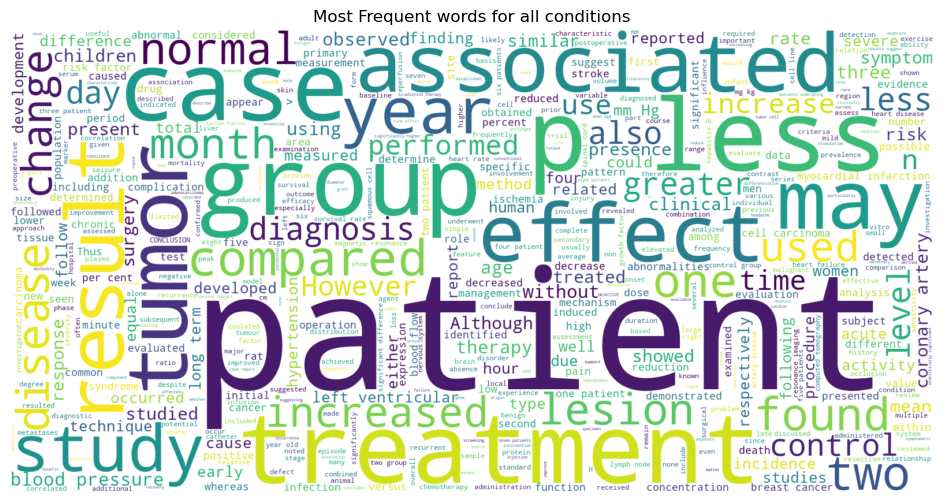

In [89]:
plt.figure(figsize=(12,6))
plt.title('Most Frequent words for all conditions')
wc = WordCloud(background_color='white', max_words = 500, width=1600, height=800, contour_width=10, contour_color='steelblue', stopwords = stopwords).generate(" ".join(df['abstract']))
plt.axis(False)
plt.imshow(wc, interpolation='bilinear');

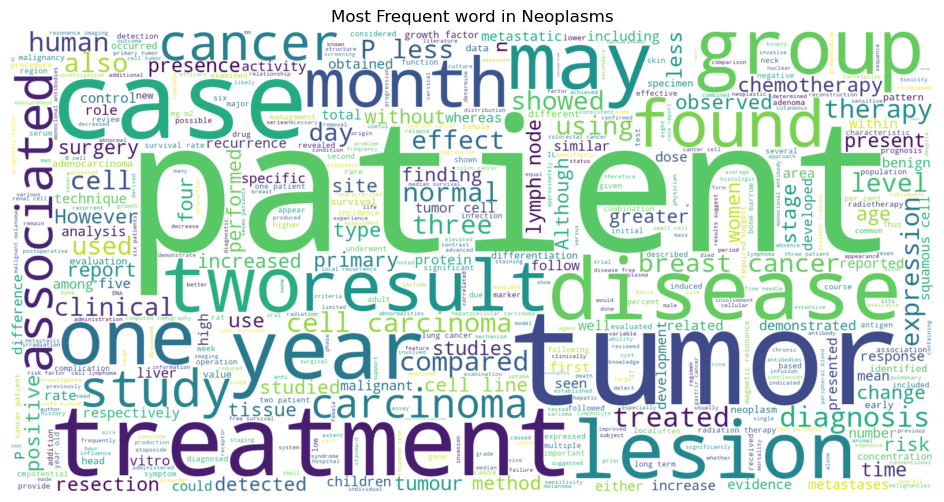

In [90]:
plt.figure(figsize=(12,6))
plt.title('Most Frequent word in Neoplasms')
wc = WordCloud(background_color='white', max_words = 500, width=1600, height=800, contour_width=10, contour_color='steelblue', stopwords = stopwords).generate(" ".join(df[df['condition'] == 'neoplasm']['abstract']))
plt.axis(False)
plt.imshow(wc, interpolation='bilinear');

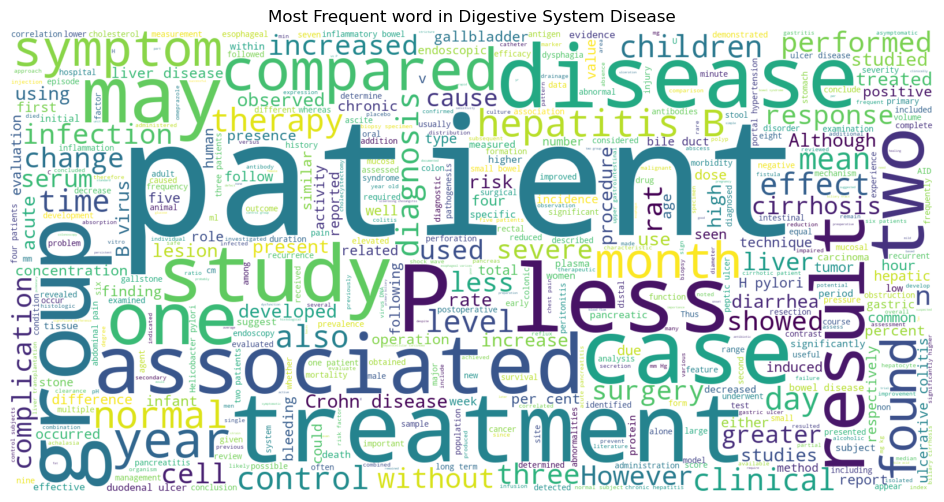

In [91]:
plt.figure(figsize=(12,6))
plt.title('Most Frequent word in Digestive System Disease')
wc = WordCloud(background_color='white', max_words = 500, width=1600, height=800, contour_width=10, contour_color='steelblue', stopwords = stopwords).generate(" ".join(df[df['condition'] == 'digestive system disease']['abstract']))
plt.axis(False)
plt.imshow(wc, interpolation='bilinear');

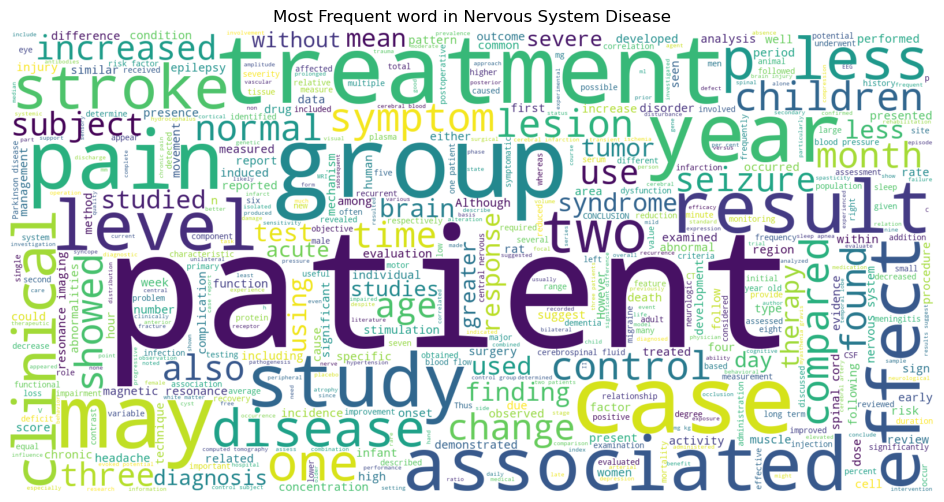

In [92]:
plt.figure(figsize=(12,6))
plt.title('Most Frequent word in Nervous System Disease')
wc = WordCloud(background_color='white', max_words = 500, width=1600, height=800, contour_width=10, contour_color='steelblue', stopwords = stopwords).generate(" ".join(df[df['condition'] == 'nervous system disease']['abstract']))
plt.axis(False)
plt.imshow(wc, interpolation='bilinear');

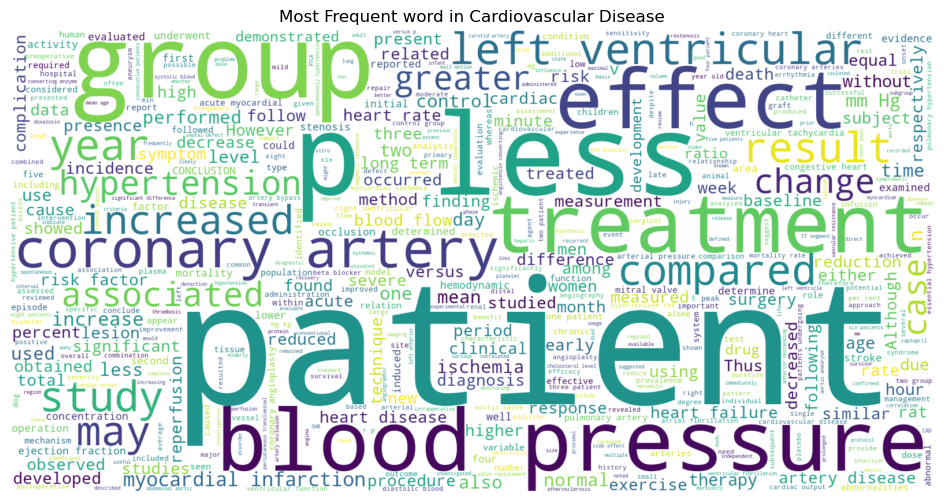

In [93]:
plt.figure(figsize=(12,6))
plt.title('Most Frequent word in Cardiovascular Disease')
wc = WordCloud(background_color='white', max_words = 500, width=1600, height=800, contour_width=10, contour_color='steelblue', stopwords = stopwords).generate(" ".join(df[df['condition'] == 'cardiovascular disease']['abstract']))
plt.axis(False)
plt.imshow(wc, interpolation='bilinear');